# Paddy competition locally

On paperspace, I moved training dataset to be local. Hopefully it provides speed ups.

We will get started with [Paddy](https://www.kaggle.com/competitions/paddy-disease-classification) competition from Kaggle.

Last blog, we went over how to setup kaggle API and download data. We will use data from last time and create a submission. At this point, our goal is not to get to the top of the submissions, but to create a baseline. We just want our model to train reasonably well, so that we can make improvements on it later. 

We first 

In [1]:
from fastai.vision.all import *

In [3]:
path = Path('/root/paddy')
Path.BASE_PATH = path
path.ls()

(#1) [Path('train_images')]

## Explore data

Before we do anything, we can look at the data to find out how they are structured. It's helpful to read [data](https://www.kaggle.com/competitions/paddy-disease-classification/data) section of the competition as well. 

In [4]:
trn_path = path/'train_images'
trn_path.ls()

(#12) [Path('train_images/bacterial_leaf_streak'),Path('train_images/hispa'),Path('train_images/models'),Path('train_images/normal'),Path('train_images/blast'),Path('train_images/dead_heart'),Path('train_images/bacterial_leaf_blight'),Path('train_images/res34_12.pkl'),Path('train_images/tungro'),Path('train_images/bacterial_panicle_blight')...]

In [5]:
files = get_image_files(trn_path)
files

(#10407) [Path('train_images/bacterial_leaf_streak/100081.jpg'),Path('train_images/bacterial_leaf_streak/104135.jpg'),Path('train_images/bacterial_leaf_streak/108249.jpg'),Path('train_images/bacterial_leaf_streak/100235.jpg'),Path('train_images/bacterial_leaf_streak/105265.jpg'),Path('train_images/bacterial_leaf_streak/109925.jpg'),Path('train_images/bacterial_leaf_streak/106054.jpg'),Path('train_images/bacterial_leaf_streak/103307.jpg'),Path('train_images/bacterial_leaf_streak/106974.jpg'),Path('train_images/bacterial_leaf_streak/101151.jpg')...]

We can see that image labels are divided by folders. 

Let's now look at an image and its size. It is (192, 256). We can check sizes of others as well.

(192, 256)


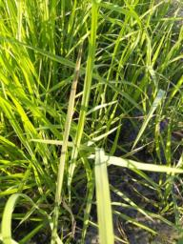

In [6]:
im = PILImage.create(files[0])
print(im.size)
im.to_thumb(244)

We can check sizes of all the images fast using parallel. It has some restrictions, but it makes it faster. However, it is not guaranteed to be fast as overhead can be from Input/Output of files. For instance, in paperspace instance, it took almost the same amount of time whether I used parallel or not because my files were in cloud. So, it was taking a long time due to internet, not CPU.

In [7]:
from fastcore.parallel import *

def get_img_size(path):
    return PILImage.create(path).size

sizes = parallel(get_img_size, files)
sizes

(#10407) [(192, 256),(192, 256),(192, 256),(192, 256),(192, 256),(192, 256),(192, 256),(192, 256),(192, 256),(192, 256)...]

In [8]:
sizes = pd.Series(sizes)
sizes.value_counts()

(192, 256)    10403
(256, 192)        4
dtype: int64

Except for 4 images, everything had the same sizes. 

## Create dataloaders

Now, we can create an Image Dataloaders from the folders. It is very easy with fastai. We only have to provide path to look for data, how to split validation and train data, and how to transfor images. fastai figures out everything else for us, such as how to process images and labels and creating batches.

In [9]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize(size=(244)),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
)

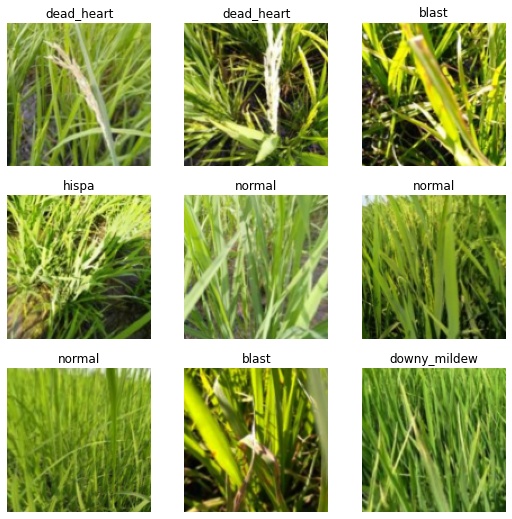

In [10]:
dls.show_batch()

It's very important to look at images here and see whether they are labeled correctly. If these are not correctly labelled, we have to go back and fix path or whatever that was wrong. If it is wrong, even if we train it, it won't be 

## Learner

In [11]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.002511886414140463)

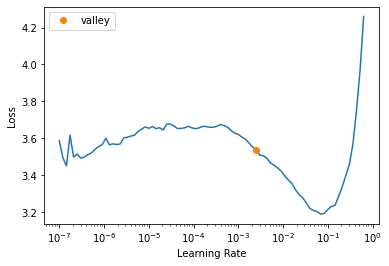

In [12]:
learn.lr_find()

In [13]:
learn.fine_tune(12, base_lr=0.008)

epoch,train_loss,valid_loss,error_rate,time
0,2.004129,1.394192,0.439692,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.927082,0.576492,0.184046,00:44
1,0.677962,0.499539,0.155694,00:43
2,0.599305,0.519338,0.159539,00:43
3,0.547356,0.471709,0.151370,00:43
4,0.440696,0.508961,0.152811,00:43
5,0.356335,0.307350,0.082653,00:44
6,0.286753,0.258723,0.065834,00:43
7,0.204371,0.195909,0.053340,00:43
8,0.133023,0.162864,0.038924,00:43
9,0.088292,0.145632,0.037001,00:43


In [24]:
doc(learn.fit_one_cycle)

In [25]:
learn.export('res34_12.pkl')

## Inference

In [29]:
ss = pd.read_csv('sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [31]:
test_path = get_image_files(path/'test_images').sorted()
test_path

(#3469) [Path('test_images/200001.jpg'),Path('test_images/200002.jpg'),Path('test_images/200003.jpg'),Path('test_images/200004.jpg'),Path('test_images/200005.jpg'),Path('test_images/200006.jpg'),Path('test_images/200007.jpg'),Path('test_images/200008.jpg'),Path('test_images/200009.jpg'),Path('test_images/200010.jpg')...]

In [34]:
test_dl = dls.test_dl(test_path)
test_dl

In [36]:
probs,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)

In [37]:
idxs

TensorBase([7, 8, 3,  ..., 8, 1, 5])

In [39]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [41]:
idxs = pd.Series(idxs)
idxs

0       7
1       8
2       3
3       3
4       3
       ..
3464    5
3465    7
3466    8
3467    1
3468    5
Length: 3469, dtype: int64

In [42]:
mapping = dict(enumerate(dls.vocab))
mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [46]:
results = idxs.map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Length: 3469, dtype: object

In [48]:
ss.label = results
ss

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [49]:
ss.to_csv('subm.csv', index=False)

In [50]:
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
